In [42]:
import os
import PIL
import cv2
import pathlib
import winsound
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline 

## Dataset
The textile fabric database consists of 245 images of 7 different fabrics. There are 140 defect-free images, 20 for each type of fabric. With different types of defects, there are 105 images.

Images have a size of 4096×256 pixels. Defective images have been denominated as follows: nnnn_ddd_ff.png, where nnnn is the image number, ddd is the defect code, and ff is the fabric code.

In [21]:
dataset_folder = "..\\archive"  
no_defect_images_folder = os.path.join(dataset_folder, "NODefect_images")
defect_images_folder = os.path.join(dataset_folder, "Defect_images")
mask_images_folder = os.path.join(dataset_folder, "Mask_images")

def gather_filenames(mypath: os.path) -> list[str]:
    filepaths = []
    for path, _, files in os.walk(mypath):
        for name in files:
            filepaths.append(os.path.join(path, name))
    return filepaths

defect_file_paths = gather_filenames(defect_images_folder)
no_defect_file_paths = gather_filenames(no_defect_images_folder)

print(f'Defects found: {len(defect_file_paths)}\nNo Defects found: {len(no_defect_file_paths)}')


Defects found: 106
No Defects found: 141


In [22]:
# Selected defects
DEFECT_CODES = {
    0:  'No defect',
    2:	'Broken end',
    6:	'Broken yarn',
    # 10:	'Broken pick',
    # 16:	'Weft curling',
    # 19:	'Fuzzyball',
    # 22: 'Cut selvage',
    23: 'Crease',  
    # 25:	'Warp ball',
    # 27: 'Knots',
    # 29: 'Contamination',
    30:  'Nep',
    # 36: 'Weft crack'
}
output_len = len(DEFECT_CODES)

#encode defects to 0-12
DEFECT_ENCODINGS = {}
for i, key in zip(range(len(DEFECT_CODES)) , DEFECT_CODES.keys()):
    DEFECT_ENCODINGS[key] = i

def extract_labels(filepaths: list[str]) -> pd.DataFrame:
    file_df = pd.DataFrame(filepaths, columns=['filepath'])

    # x.split('\\') willl give the filename, then x.split('_') will give the labels
    file_df['id'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[0]))
    file_df['defect'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[1]))
    file_df['fabric'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[2].split('.')[0]))
    return file_df

# add Id, defect code, and fabric code to file df 
defect_file_df = extract_labels(defect_file_paths)
no_defect_file_df = extract_labels(no_defect_file_paths)

In [23]:
# drop unwanted labels
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 10].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 16].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 19].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 22].index)
# defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 23].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 25].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 27].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 29].index)
# defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 30].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 36].index)

# Select Defects to encode
defect_file_df['defect'] = defect_file_df['defect'].map(lambda x: DEFECT_ENCODINGS[x])
no_defect_file_df['defect'] = no_defect_file_df['defect'].map(lambda x: DEFECT_ENCODINGS[x])
full_file_df = pd.concat([defect_file_df, no_defect_file_df])

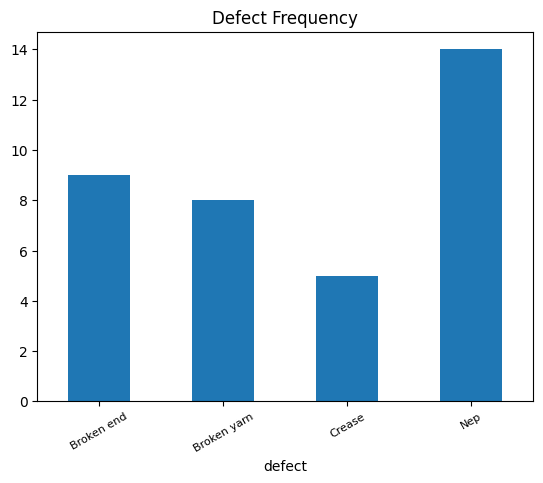

In [24]:
ax = defect_file_df['defect'].value_counts().sort_index().plot(kind = 'bar', title='Defect Frequency')
plt.xticks(range(0,len(DEFECT_CODES) - 1), list(DEFECT_CODES.values())[1:])
ax.xaxis.set_tick_params(rotation=30, labelsize=8)
plt.gca().spines[['top', 'right',]].set_visible(True)

In [47]:
def split_train_test(full_file_df):

    full_file_df = full_file_df.sample(frac= 1, random_state= 7)

    train_defect_dfs = []
    test_defect_dfs = []
    for defect_code in range(len(DEFECT_CODES)):

        defect_type = full_file_df.loc[full_file_df['defect'] == defect_code]

        train, test = train_test_split(defect_type, test_size=0.20)

        train_defect_dfs.append(train)
        test_defect_dfs.append(test)
        
    train_df = pd.concat(train_defect_dfs).reset_index()
    test_df = pd.concat(test_defect_dfs).reset_index()

    return train_df, test_df

full_file_df = pd.concat([defect_file_df, no_defect_file_df])
train_df, test_df = split_train_test(full_file_df)

In [64]:
def load_image(file_path: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=1)
    return image, label

def augment(image, label, seed):
    # Make new seed
    new_seed = tf.random.split(seed, num=1)[0, :]
    # Random brightness.
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed
    )
    # random vertical flip
    image = tf.image.stateless_random_flip_up_down(
        image, seed=new_seed
    )

    image = tf.image.stateless_random_contrast(
        image, 0.2, 0.5, seed
    )

    image = tf.clip_by_value(image, 0, 255)
    
    return image, label

def augment_update_seed(image, label, rng):
    seed = rng.make_seeds(1)[:, 0]
    image, label = augment(image, label, seed)
    return image, label

def augment_defect_images(train_ds):
    # used to create more defect images,
    # just a flip, brightness, contrast change 
    no_defect_train_image_ds = train_ds.filter(lambda _, label: label == 0)
    num_no_defects =  len(list(no_defect_train_image_ds.as_numpy_iterator()))

    defect_train_image_ds = train_ds.filter(lambda _, label: label > 0)
    num_defects =  len(list(defect_train_image_ds.as_numpy_iterator()))
    
    rng = tf.random.Generator.from_seed(123, alg='philox')
    augments_per_image = 6
    augmented_defects_ds = (
        defect_train_image_ds
        .repeat(augments_per_image)
        .map(lambda image, label: augment_update_seed(image, label, rng))
    )
    
    # print(f"Number of defects before augmentation: {len(list(defect_train_image_ds.as_numpy_iterator()))}\n")
    # print(f"Number of defects after augmentation: {len(list(augmented_defects_ds.as_numpy_iterator()))}\n")
    # print(f"Number of no-defects: {len(list(no_defect_train_image_ds.as_numpy_iterator()))}\n")
    
    augmented_defects_ds = defect_train_image_ds.concatenate(augmented_defects_ds)

    return augmented_defects_ds.concatenate(no_defect_train_image_ds), (num_defects * augments_per_image) + num_defects + num_no_defects


#preprocess images
def preprocess_img(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    image = tf.cast(image, tf.uint8)
    image -= tf.reduce_mean(image, axis=0)          # Normalize 
    image = tf.image.grayscale_to_rgb(image)        # Grey scale
    image = tf.image.resize(image, [224, 224])      # Resize
    return image, label

In [69]:
def prepare_data(train_df, test_df):
    # Df to tensorflow Ds
    train_files_arr = train_df['filepath'].to_numpy()
    train_labels_arr = train_df['defect'].to_numpy()
    train_ds = tf.data.Dataset.from_tensor_slices((train_files_arr, train_labels_arr))
    
    # # Split val_df into 2 for test and val

    # val_df = test_df.sample(frac= 1/2, random_state= 2, axis= 0)
    # test_df = test_df.drop(val_df.index)

    # test_df = test_df.reset_index()
    # val_df = val_df.reset_index()

    # Df to tensorflow Ds
    test_files_arr = test_df['filepath'].to_numpy()
    test_labels_arr = test_df['defect'].to_numpy()
    test_ds = tf.data.Dataset.from_tensor_slices((test_files_arr, test_labels_arr))

    # Df to tensorflow Ds
    val_files_arr = test_df['filepath'].to_numpy()
    val_labels_arr = test_df['defect'].to_numpy()
    val_ds = tf.data.Dataset.from_tensor_slices((val_files_arr, val_labels_arr))

    # load filepath to image
    val_ds = val_ds.map(load_image)
    test_ds = test_ds.map(load_image)
    train_ds = train_ds.map(load_image)

    # Augment the training images
    aug_train_ds, aug_image_num = augment_defect_images(train_ds)

    val_ds = val_ds.map(lambda image, label: preprocess_img(image, label))
    test_ds = test_ds.map(lambda image, label: preprocess_img(image, label))
    train_ds = train_ds.map(lambda image, label: preprocess_img(image, label))
    aug_train_ds = aug_train_ds.map(lambda image, label: preprocess_img(image, label))

    enc = OneHotEncoder()
    enc.fit([[i] for i in list(range(len(DEFECT_CODES)))])

    spec = tf.TensorSpec(shape=[len(DEFECT_CODES),], dtype=tf.int64)
    @tf.py_function(Tout=spec)
    def defect_to_one_hot(label):
        label = enc.transform(
            label.numpy().reshape(1, 1)
            ).toarray()[0]
        return label
    
    val_ds = val_ds.map(lambda image, label: (image, defect_to_one_hot(label)))
    test_ds = test_ds.map(lambda image, label: (image, defect_to_one_hot(label)))
    train_ds = train_ds.map(lambda image, label: (image, defect_to_one_hot(label)))
    aug_train_ds = aug_train_ds.map(lambda image, label: (image, defect_to_one_hot(label)))
    num_augments = len(list(aug_train_ds.as_numpy_iterator()))

    val_ds = val_ds.batch(4, drop_remainder=True)
    test_ds = test_ds.batch(4, drop_remainder=True)
    train_ds = train_ds.batch(4, drop_remainder=True)
    aug_train_ds = aug_train_ds.batch(4, drop_remainder=True)

    for i in aug_train_ds:
        train_shape = (i[0].shape, i[1].shape)
        break

    def set_shapes(image, label):
        image.set_shape(train_shape[0])
        label.set_shape(train_shape[1])
        return image, label
    
    aug_train_ds = aug_train_ds.map(set_shapes)

    num_batches = len(list(aug_train_ds.as_numpy_iterator()))
    aug_train_ds = aug_train_ds.apply(tf.data.experimental.assert_cardinality(num_batches))

    return aug_train_ds, train_ds, val_ds, test_ds

aug_train_ds, train_ds, val_ds, test_ds = prepare_data(train_df, test_df)

In [70]:
def display_tensor_as_image(tensor: tf.Tensor):
    print(tensor.shape)
    plt.gray()
    plt.imshow(tensor.numpy())
    plt.show()

## Supervised Learning

In [71]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(15,15))
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train','Val'])
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])

In [72]:
def f1_score_matrix(val_ds, head_model):    
    metric = tf.keras.metrics.F1Score()

    test_y_true_ds = [label.numpy() for _, label in val_ds.unbatch()]
    test_y_true_ds = np.array(test_y_true_ds)
    test_y_pred_ds = head_model.predict(val_ds, verbose=2)

    metric.update_state(test_y_true_ds, test_y_pred_ds)
    result = metric.result()

    true_labels = np.array([np.argmax(label) for label in test_y_true_ds])
    pred_labels = np.array([np.argmax(label) for label in test_y_pred_ds])
    return result.numpy(), tf.math.confusion_matrix(true_labels, pred_labels, num_classes=5)


In [73]:
# Transfer learning on the top layers
# Load convolutional weights that are trained on ImageNet data
def build_model(output_len):
    base_model = tf.keras.applications.resnet.ResNet152(
        weights = 'imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )

    # Freeze pretrained layers
    for layer in base_model.layers:
      layer.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    predictions = tf.keras.layers.Dense(output_len, activation = 'softmax')(x)

    head_model = tf.keras.Model(inputs = base_model.input, outputs = predictions)
    head_model.compile(optimizer='adam', loss= tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return head_model


Epoch 1/6

77/77 [==============================] - 114s 1s/step - loss: 24.1743 - accuracy: 0.7662 - val_loss: 3.1341 - val_accuracy: 0.8056
Epoch 2/6
77/77 [==============================] - 98s 1s/step - loss: 39.6315 - accuracy: 0.7338 - val_loss: 3.1341 - val_accuracy: 0.8056
Epoch 3/6
77/77 [==============================] - 99s 1s/step - loss: 11.5940 - accuracy: 0.7857 - val_loss: 2.6863 - val_accuracy: 0.8333
Epoch 4/6
77/77 [==============================] - 99s 1s/step - loss: 9.1940 - accuracy: 0.8117 - val_loss: 1.3432 - val_accuracy: 0.9167
Epoch 5/6
77/77 [==============================] - 98s 1s/step - loss: 2.3400 - accuracy: 0.8734 - val_loss: 0.8613 - val_accuracy: 0.9167
Epoch 6/6
9/9 [==============================] - 5s 557ms/step - loss: 0.5064 - accuracy: 0.9444
9/9 - 8s - 8s/epoch - 876ms/step
9/9 - 5s - 5s/epoch - 570ms/step
0.9444444179534912 [0.9655172 1.        0.8       1.        0.6666667] tf.Tensor(
[[28  0  1  0  0]
 [ 0  2  0  0  0]
 [ 0  0  2  0  0]
 

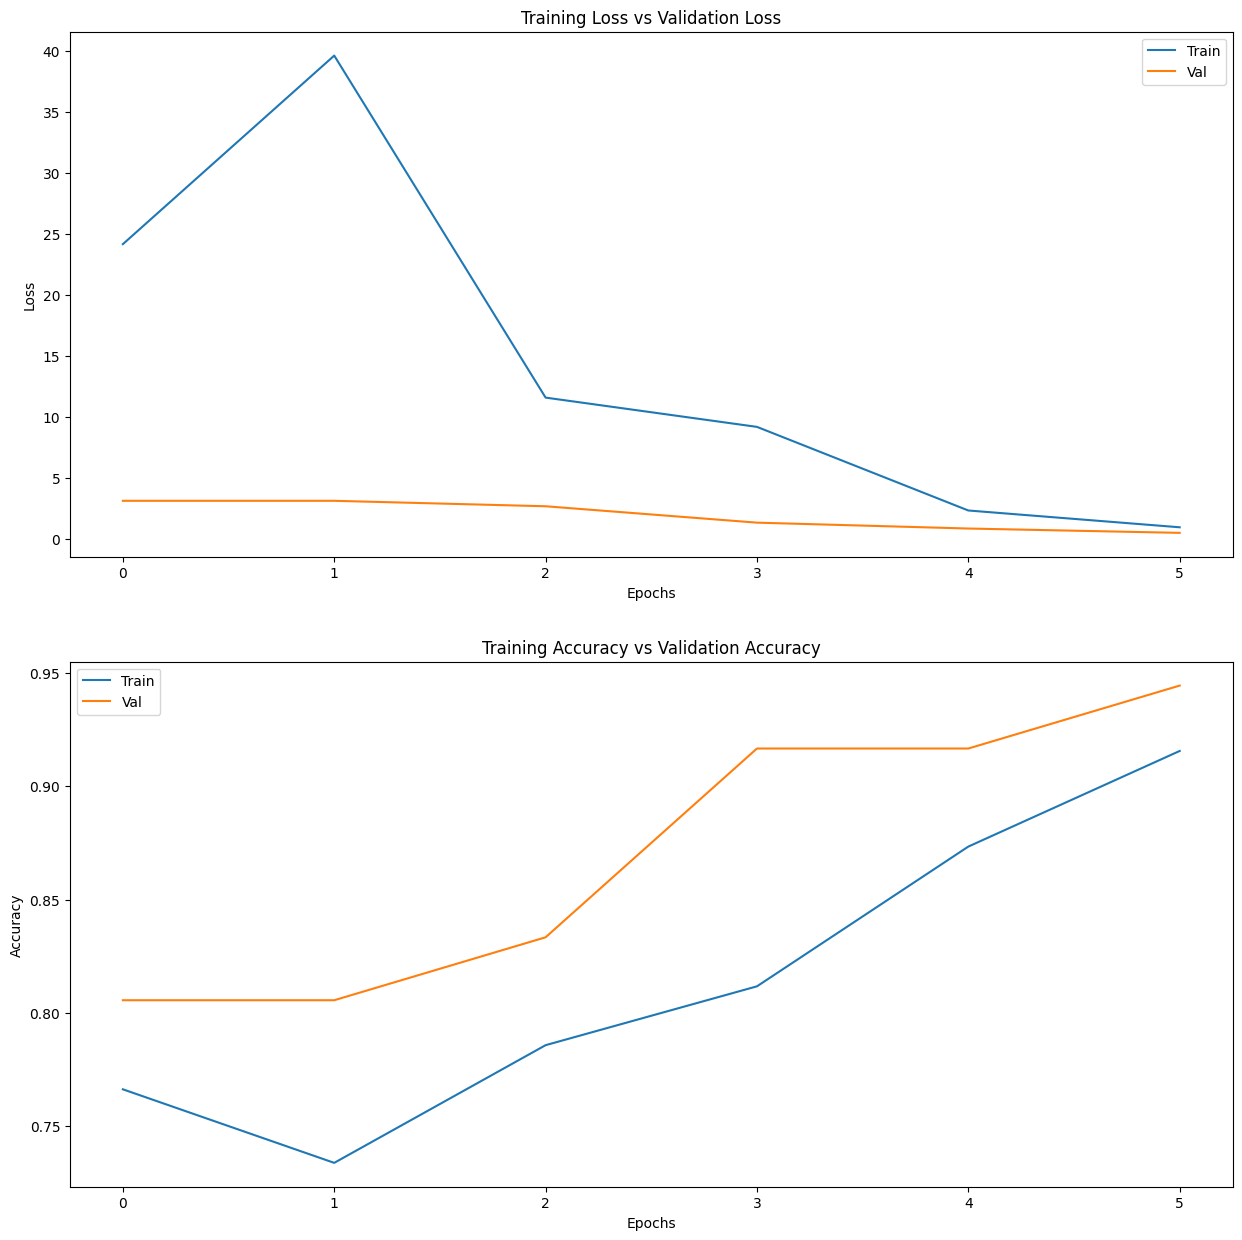

In [74]:
# Create pretrained model
head_model = build_model(output_len)

# train
history = head_model.fit(aug_train_ds, epochs= 6, validation_data= val_ds)
plot_history(history)

#Gather Metrics 
acc = head_model.evaluate(val_ds)[1]
f_1 = f1_score_matrix(val_ds, head_model)[0]
con_matrix = f1_score_matrix(val_ds, head_model)[1]
print(acc, f_1, con_matrix)

In [75]:
def new_kfolds(full_file_df):
    # Shuffle df
    full_file_df = full_file_df.sample(frac= 1, random_state= 7)

    # get each defect type
    train_defects_folds = []
    test_defects_folds = []
    for defect_code in range(len(DEFECT_CODES)):
        defect_type = full_file_df.loc[full_file_df['defect'] == defect_code]
        kf = KFold(shuffle=False)
        train_defect_df = []
        test_defect_df = []
        # Get test and train for each code
        for train_idx, test_idx in kf.split(defect_type):
            train_defect_df.append(defect_type.iloc[train_idx])
            test_defect_df.append(defect_type.iloc[test_idx])
        
        train_defects_folds.append(train_defect_df)
        test_defects_folds.append(test_defect_df)

    # Arrange data by fold
    train_folds = []
    for fold in range(5):
        fold_defects = []
        for defects in train_defects_folds:
            fold_defects.append(defects[fold])
        train_folds.append(pd.concat(fold_defects).reset_index())
    
    val_folds = []
    for fold in range(5):
        fold_defects = []
        for defects in test_defects_folds:
            fold_defects.append(defects[fold])
        val_folds.append(pd.concat(fold_defects).reset_index())
    return zip(train_folds, val_folds)  


def eval_kfolds(full_file_df):
    con_matrix = None
    best_val = None
    best_train = None
    f_1 = 0 
    total_acc = 0
    largest_acc = 0
    for train_df, val_df in new_kfolds(full_file_df):

        aug_train_ds, train_ds, val_ds, test_ds = prepare_data(train_df, val_df)

        # Create pretrained model
        head_model = build_model(output_len)

        # train
        history = head_model.fit(aug_train_ds, epochs= 6, validation_data= val_ds)
        plot_history(history)

        #Gather Metrics 
        acc = head_model.evaluate(val_ds)[1]

        if acc > largest_acc:
            best_train = train_ds
            best_val = val_ds
            best_model = head_model
            largest_acc = acc


        print(f'k fold {i+1} acc {acc}')
        total_acc += acc
        print(f'k fold {i+1} f score and confusion matrix {f1_score_matrix(val_ds, head_model)}')

        if con_matrix is None:
            f_1 = f1_score_matrix(val_ds, head_model)[0]
            con_matrix = f1_score_matrix(val_ds, head_model)[1]
        else:
            f_1 += f1_score_matrix(val_ds, head_model)[0]
            con_matrix += f1_score_matrix(val_ds, head_model)[1]

    total_acc = total_acc/(i+1)
    f_1 = f_1/(i+1)
    return total_acc, f_1, con_matrix, best_model, best_train, best_val


Epoch 1/6
77/77 [==============================] - 108s 1s/step - loss: 40.8064 - accuracy: 0.7825 - val_loss: 3.1341 - val_accuracy: 0.8056
Epoch 2/6
77/77 [==============================] - 96s 1s/step - loss: 107.8599 - accuracy: 0.7078 - val_loss: 2.2386 - val_accuracy: 0.8611
Epoch 3/6
77/77 [==============================] - 96s 1s/step - loss: 8.9467 - accuracy: 0.8344 - val_loss: 2.2386 - val_accuracy: 0.8611
Epoch 4/6
77/77 [==============================] - 96s 1s/step - loss: 10.0720 - accuracy: 0.8312 - val_loss: 1.3432 - val_accuracy: 0.9167
Epoch 5/6
77/77 [==============================] - 96s 1s/step - loss: 1.4503 - accuracy: 0.9123 - val_loss: 1.3765 - val_accuracy: 0.9167
Epoch 6/6
9/9 [==============================] - 5s 544ms/step - loss: 1.5633 - accuracy: 0.8889
k fold 5 acc 0.8888888955116272
9/9 - 8s - 8s/epoch - 859ms/step
k fold 5 f score and confusion matrix (array([0.93333334, 0.5       , 0.6666667 , 1.        , 0.6666667 ],
      dtype=float32), <tf.Tenso

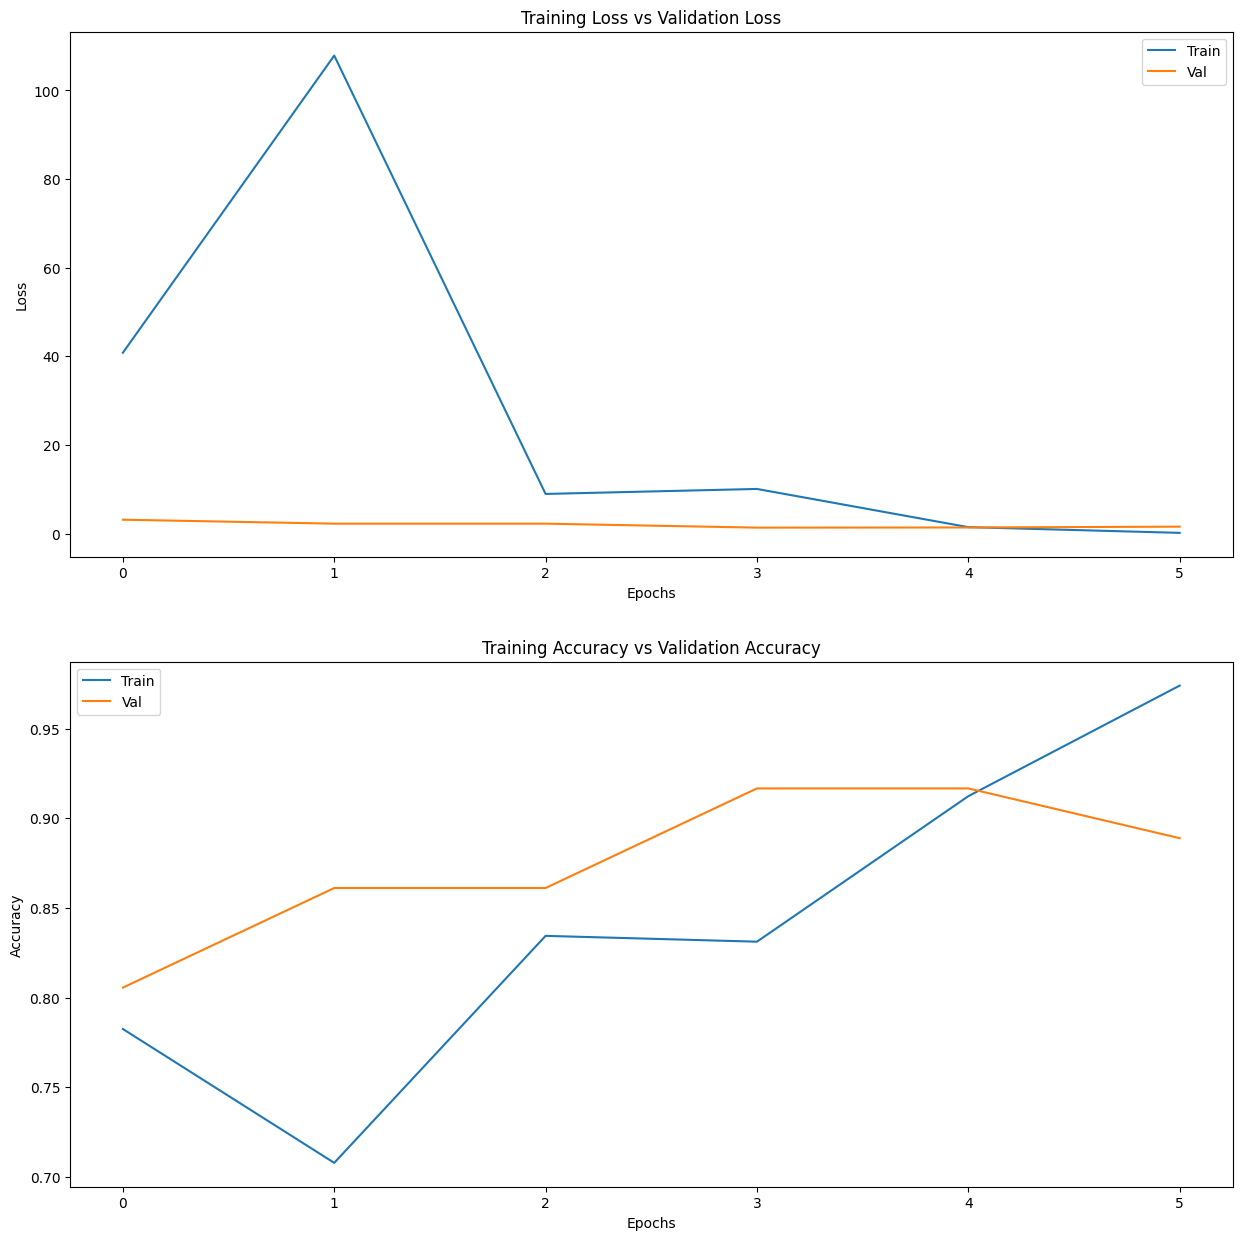

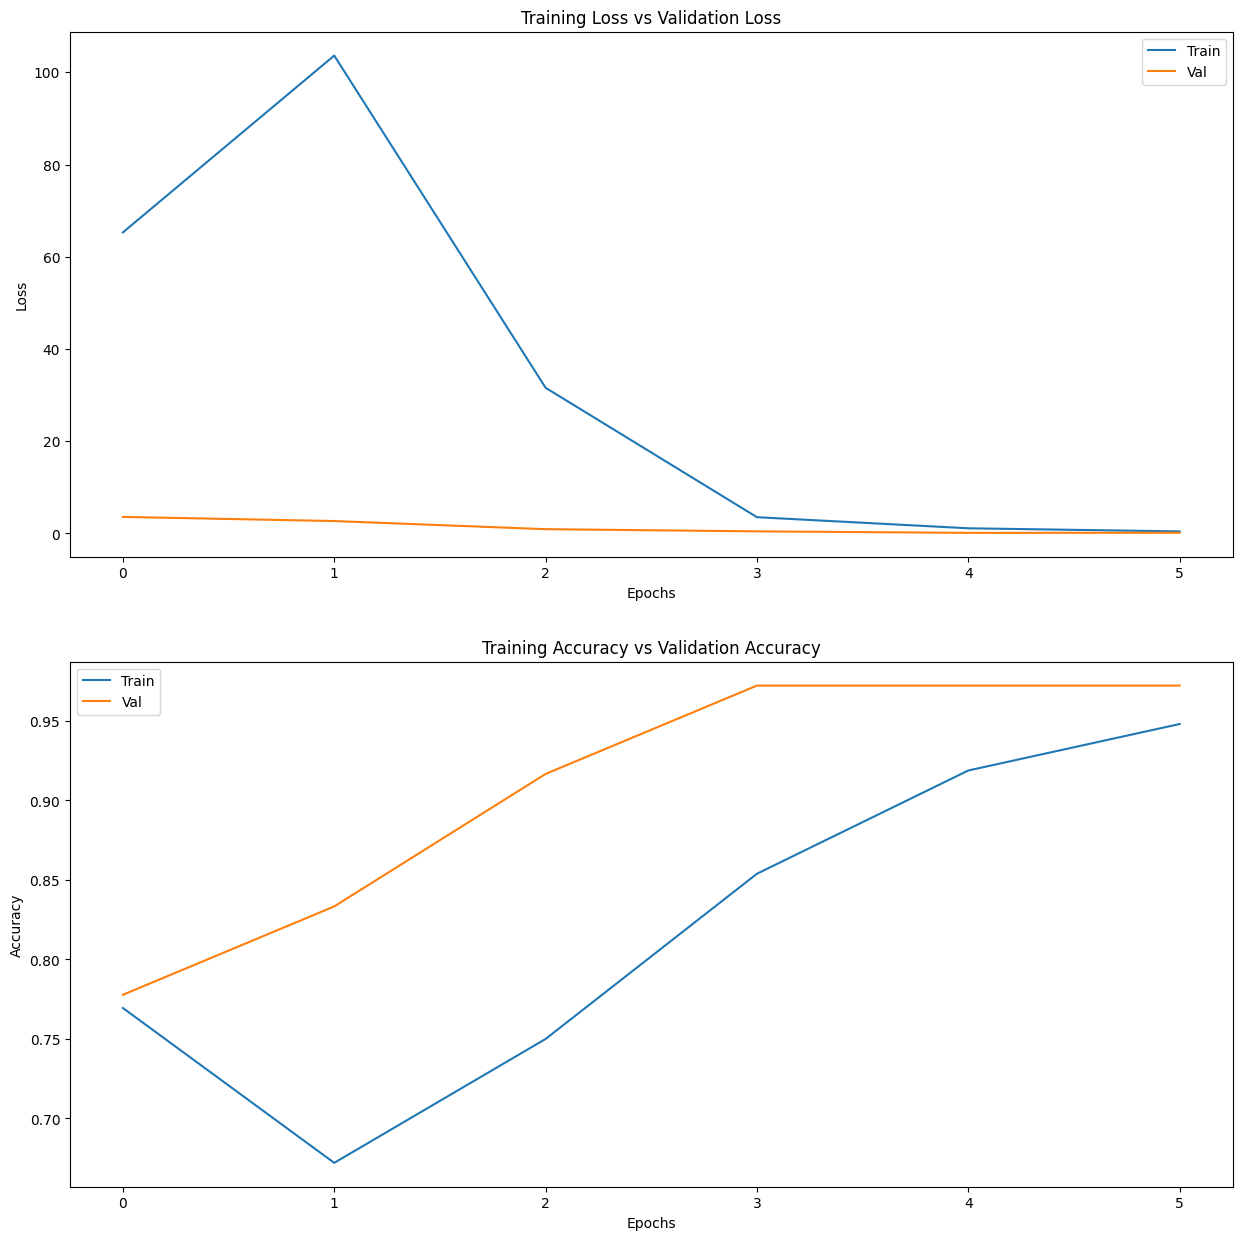

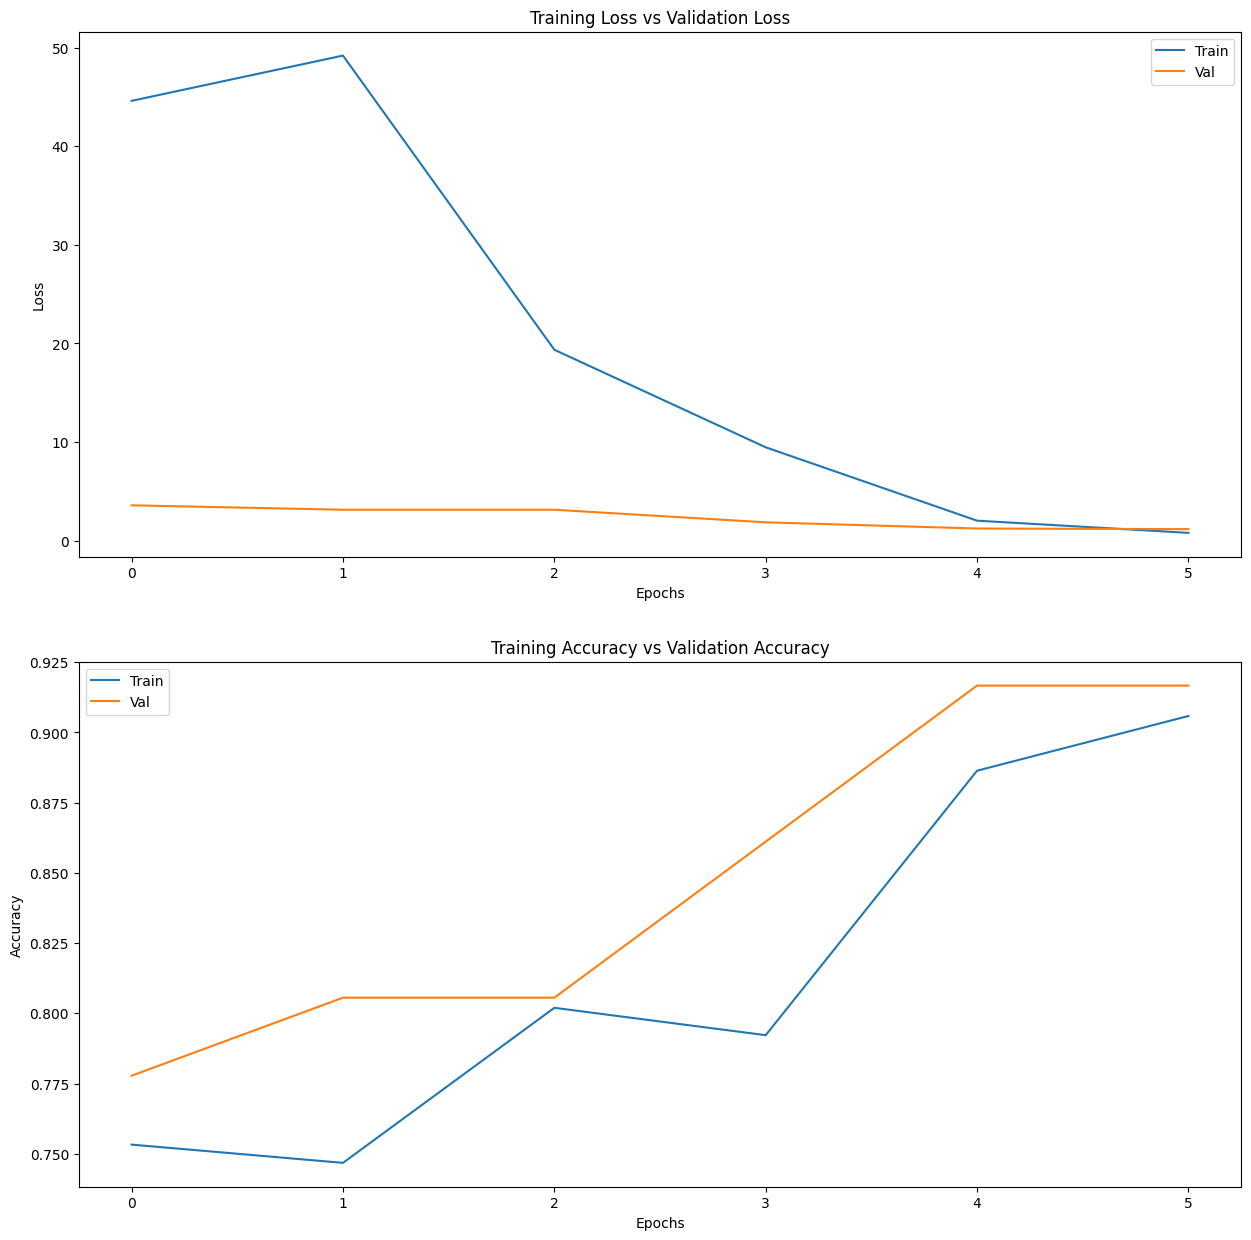

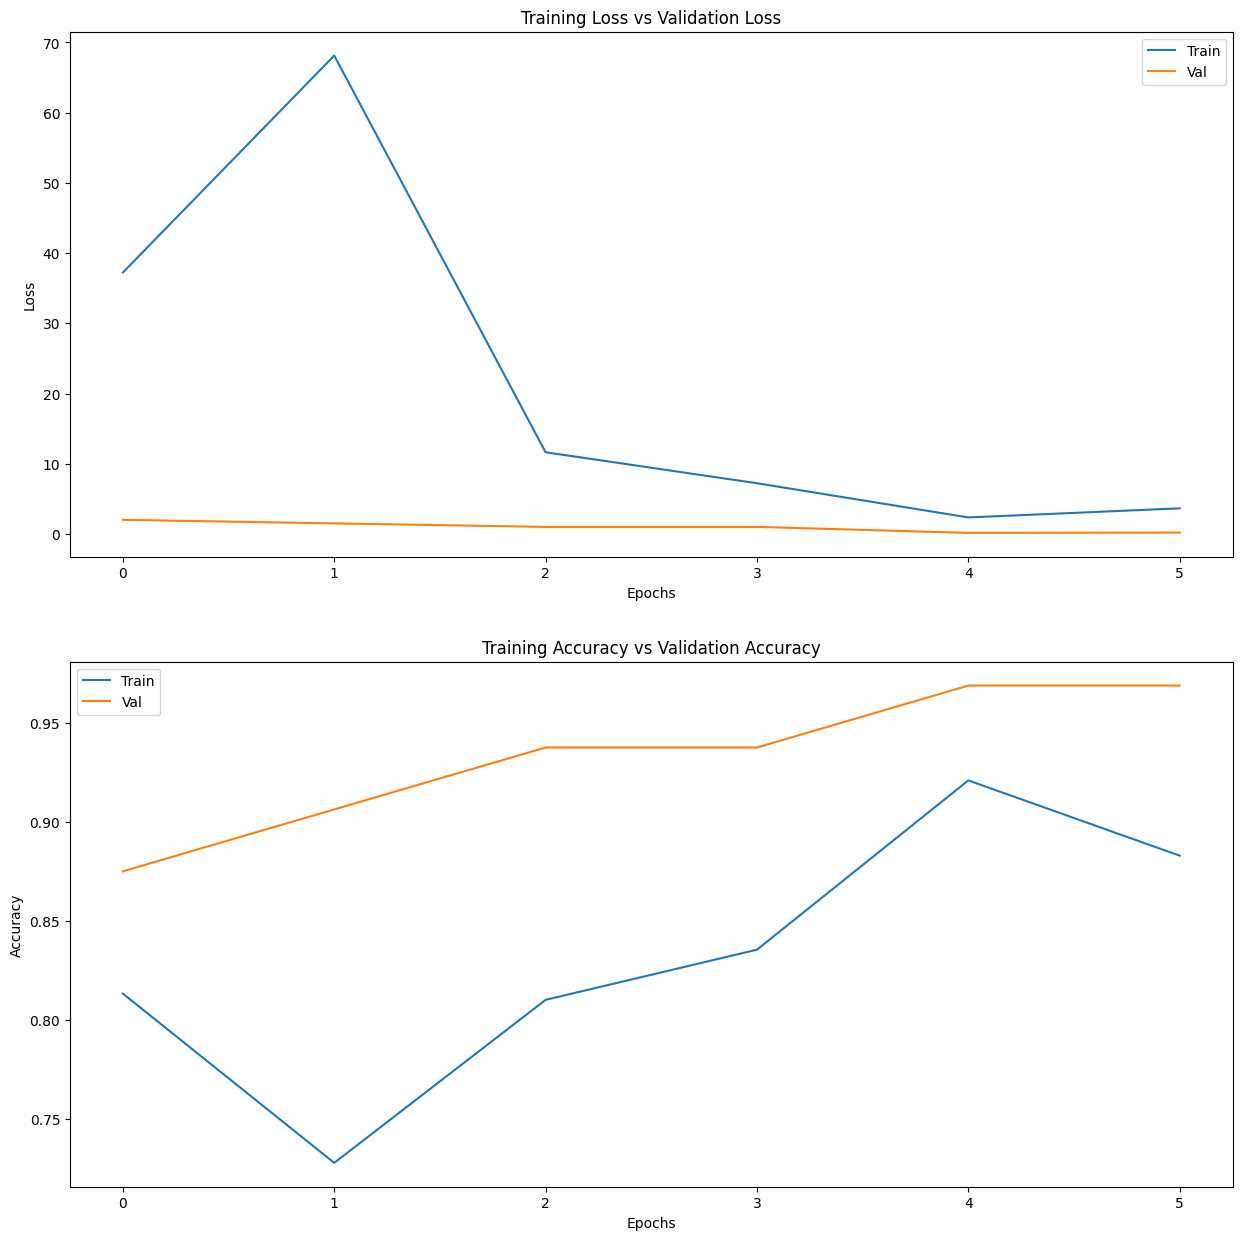

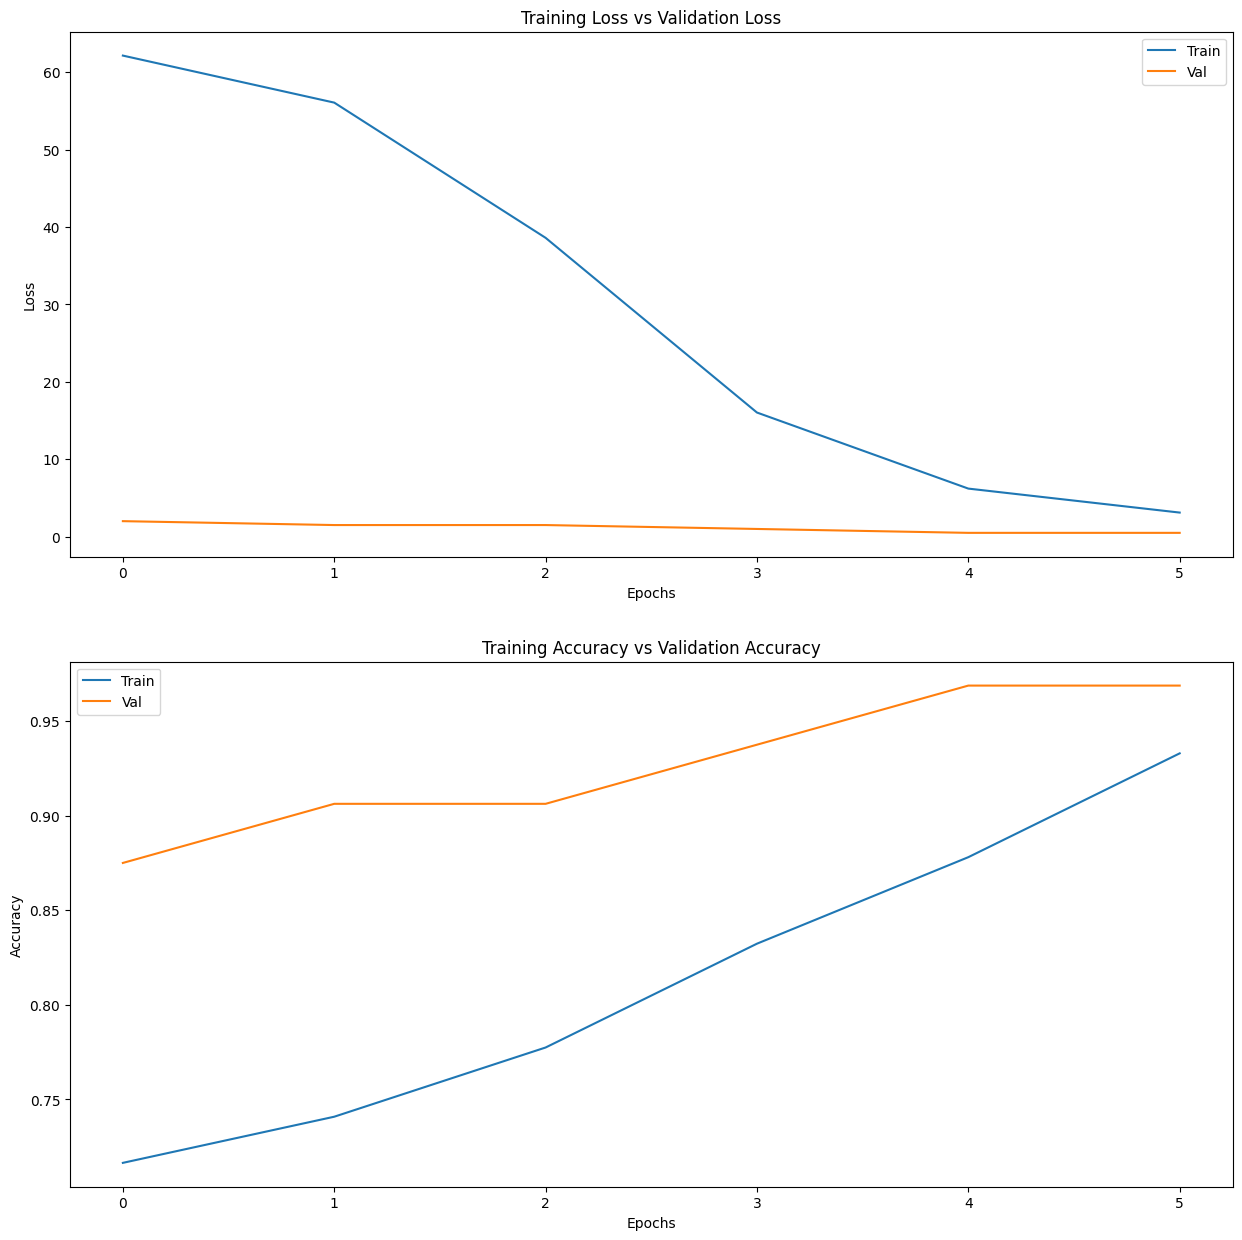

In [76]:
acc, f_1, con_matrix, best_model, best_train, best_val = eval_kfolds(full_file_df)
best_model.save('best_model.keras')
best_train.save('best_train')
best_val.save('best_val')

In [14]:
print(acc, f_1, con_matrix)

0.9444444417953491 [0.97667646 0.8666667  0.8        1.         0.31333333] tf.Tensor(
[[148   0   1   0   0]
 [  1   7   0   0   1]
 [  0   0   6   0   2]
 [  0   0   0   5   0]
 [  5   0   0   0   4]], shape=(5, 5), dtype=int32)


## Test Saved Model


In [16]:
new_model = tf.keras.models.load_model('best_model.keras')
best_train = tf.data.Dataset.load('best_train')
best_val = tf.data.Dataset.load('best_val')